# Crear CSV

In [2]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.ndimage import label, generate_binary_structure

# --- CONFIGURACIÓN DE RUTAS ---
base_dir = "/media/guest/PORT-DISK/Practicas/MicroBleeds/Test_Subset_Ensemble"
pred_dir = os.path.join(base_dir, "predictions")
gt_dir   = os.path.join(base_dir, "labelsTs")
output_csv = "/media/guest/PORT-DISK/Practicas/MicroBleeds/Resultados_Detallados_Ensemble.csv"

# -----------------------------

def get_cohort_from_header(img_path):
    """Determina la cohorte basándose en el grosor del corte (Z-spacing)"""
    try:
        img = nib.load(img_path)
        z_spacing = img.header.get_zooms()[2]
        
        if 0.7 <= z_spacing <= 0.9: return "Cohorte 2 (0.8mm)"
        elif 2.8 <= z_spacing <= 3.2: return "Cohorte 3 (3.0mm)"
        elif 3.8 <= z_spacing <= 4.2: return "Cohorte 1 (4.0mm)"
        else: return f"Other ({z_spacing:.1f}mm)"
    except:
        return "Unknown"

def calculate_lesion_metrics(gt_data, pred_data, voxel_vol):
    """
    Calcula TP, FP, FN a nivel de lesión (Connected Components)
    y devuelve los volúmenes de las lesiones detectadas vs perdidas.
    """
    # Estructura para definir conectividad (3x3x3)
    struct = generate_binary_structure(3, 2) # Conectividad 2 (bordes y caras)

    # Etiquetar componentes (cada lesión tiene un ID único: 1, 2, 3...)
    lbl_gt, n_gt = label(gt_data > 0, structure=struct)
    lbl_pred, n_pred = label(pred_data > 0, structure=struct)

    tp = 0
    fn = 0
    detected_volumes = []
    missed_volumes = []

    # 1. Analizar Ground Truth (Buscar TP y FN)
    for i in range(1, n_gt + 1):
        # Máscara de la lesión actual
        lesion_mask = (lbl_gt == i)
        lesion_size_voxels = np.sum(lesion_mask)
        lesion_vol_mm3 = lesion_size_voxels * voxel_vol

        # Comprobar si la predicción se solapa con esta lesión
        # Basta con 1 vóxel de solape para considerarlo "Detectado" en tareas de detección
        overlap = np.sum(pred_data[lesion_mask]) > 0
        
        if overlap:
            tp += 1
            detected_volumes.append(round(lesion_vol_mm3, 2))
        else:
            fn += 1
            missed_volumes.append(round(lesion_vol_mm3, 2))

    # 2. Analizar Predicciones (Buscar FP)
    # Un FP es una lesión predicha que no toca NINGUNA lesión real
    fp = 0
    for j in range(1, n_pred + 1):
        pred_lesion_mask = (lbl_pred == j)
        # Si la intersección con el GT es 0, es un Falso Positivo
        if np.sum(gt_data[pred_lesion_mask]) == 0:
            fp += 1

    return tp, fp, fn, detected_volumes, missed_volumes, n_gt, n_pred

# --- PROCESAMIENTO ---

results = []

print(f"Buscando predicciones en: {pred_dir}")
print(f"Buscando Ground Truth en: {gt_dir}")

pred_files = [f for f in os.listdir(pred_dir) if f.endswith('.nii.gz')]

for f in pred_files:
    case_id = f.replace('.nii.gz', '')
    
    # Rutas
    path_pred = os.path.join(pred_dir, f)
    path_gt = os.path.join(gt_dir, f)
    
    if not os.path.exists(path_gt):
        print(f"⚠️ Saltando {case_id}: No encuentro etiqueta GT.")
        continue

    # Cargar imágenes
    nii_pred = nib.load(path_pred)
    nii_gt = nib.load(path_gt)
    
    data_pred = nii_pred.get_fdata()
    data_gt = nii_gt.get_fdata()

    # Calcular volumen del vóxel para pasar a mm3
    zooms = nii_pred.header.get_zooms()
    voxel_vol = np.prod(zooms) # x * y * z

    # 1. Métricas Globales (Vóxel)
    intersection = np.sum((data_pred > 0) * (data_gt > 0))
    sum_volumes = np.sum(data_pred > 0) + np.sum(data_gt > 0)
    dice_voxel = (2.0 * intersection / sum_volumes) if sum_volumes > 0 else 0.0
    if sum_volumes == 0 and np.sum(data_gt) == 0: dice_voxel = 1.0 # Caso vacío perfecto

    # 2. Métricas de Lesión (Objeto)
    tp, fp, fn, det_vols, miss_vols, n_lesions_gt, n_lesions_pred = calculate_lesion_metrics(data_gt, data_pred, voxel_vol)

    # 3. Métricas Derivadas
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Sensibilidad
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Cohorte
    cohort = get_cohort_from_header(path_pred)

    # Guardar fila
    results.append({
        'case_id': case_id,
        'fold': 'Ensemble',  # Ya no es fold 0, 1... es la fusión
        'cohort': cohort,
        # Conteos
        'n_lesions_GT': n_lesions_gt,
        'n_lesions_Pred': n_lesions_pred,
        # Matriz Confusión Lesiones
        'TP': tp,
        'FP': fp,
        'FN': fn,
        # Métricas Rendimiento
        'Lesion_Precision': round(precision, 4),
        'Lesion_Recall': round(recall, 4),
        'F1_Score': round(f1, 4),
        'Dice_Voxel': round(dice_voxel, 4),
        # Datos Volumétricos
        'n_voxels_GT': int(np.sum(data_gt > 0)),
        'Total_Vol_GT_mm3': round(np.sum(data_gt > 0) * voxel_vol, 2),
        'detected_vols_mm3': str(det_vols), # Guardamos como string para que quepa en CSV
        'missed_vols_mm3': str(miss_vols)
    })

# Guardar CSV
df = pd.DataFrame(results)

# Reordenar columnas para legibilidad
cols = ['case_id', 'fold', 'cohort', 
        'F1_Score', 'Lesion_Recall', 'Lesion_Precision', 'Dice_Voxel',
        'n_lesions_GT', 'n_lesions_Pred', 'TP', 'FP', 'FN', 
        'n_voxels_GT', 'Total_Vol_GT_mm3', 
        'detected_vols_mm3', 'missed_vols_mm3']

df = df[cols] # Aplicar orden
#df.to_csv(output_csv, index=False)

print(f"Análisis completado. CSV guardado en: {os.path.abspath(output_csv)}")
print("Resumen rápido:")
print(df.groupby('cohort')[['F1_Score', 'Lesion_Recall', 'Dice_Voxel']].mean())

Buscando predicciones en: /media/guest/PORT-DISK/Practicas/MicroBleeds/Test_Subset_Ensemble/predictions
Buscando Ground Truth en: /media/guest/PORT-DISK/Practicas/MicroBleeds/Test_Subset_Ensemble/labelsTs


KeyboardInterrupt: 

# Analizar CSV


=== RESUMEN ESTADÍSTICO ===
Total Pacientes Analizados: 13

--- MEDIAS GLOBALES ---
F1_Score            0.604708
Lesion_Recall       0.654758
Lesion_Precision    0.611108
Dice_Voxel          0.461383
dtype: float64

--- POR COHORTE ---
        F1_Score       Lesion_Recall       Lesion_Precision       Dice_Voxel  \
            mean count          mean count             mean count       mean   
cohort                                                                         
1.0     0.923100     1      0.857100     1          1.00000     1   0.750000   
2.0     0.333333     6      0.416667     6          0.30555     6   0.301983   
3.0     0.866680     5      0.900000     5          0.90000     5   0.594940   

              
       count  
cohort        
1.0        1  
2.0        6  
3.0        5  


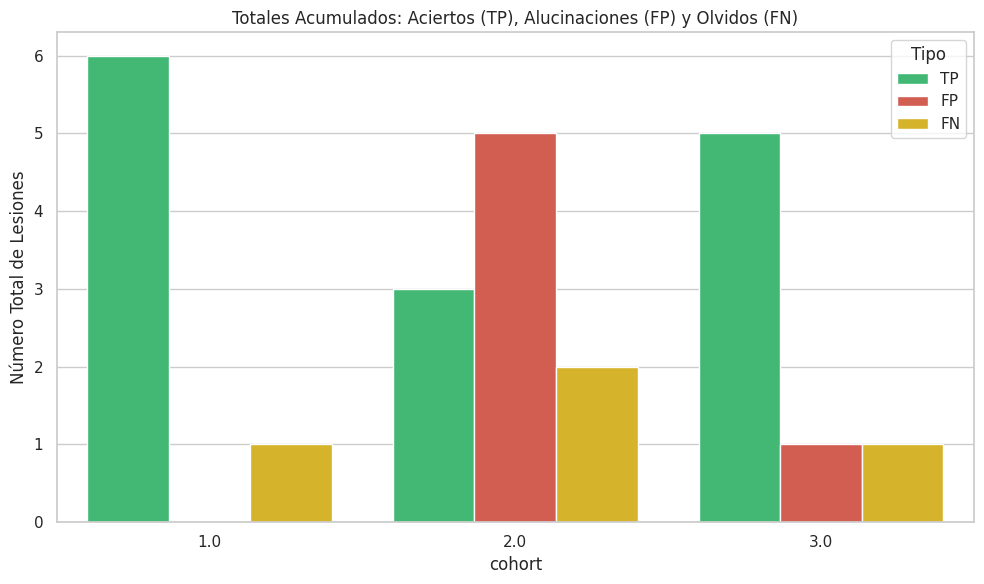

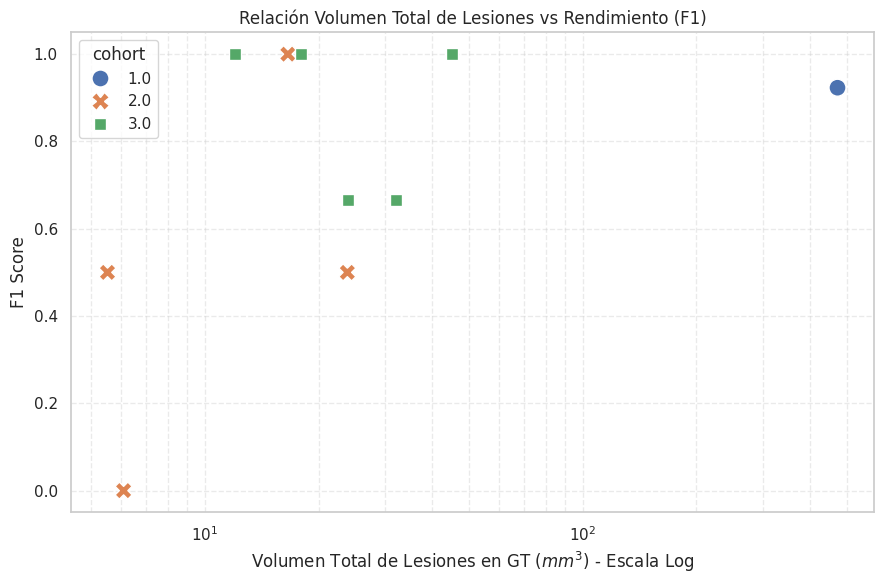

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURACIÓN ---
input_csv = "/media/guest/PORT-DISK/Practicas/MicroBleeds/Resultados_Detallados_Ensemble_Filtrados.csv"
# ---------------------

# Cargar datos
try:
    df = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: No encuentro el archivo {input_csv}")
    exit()

# 1. Calcular métricas globales
metrics = ['F1_Score', 'Lesion_Recall', 'Lesion_Precision', 'Dice_Voxel']
global_means = df[metrics].mean()
global_std = df[metrics].std()

# 2. Desglose por Cohorte
#cohort_stats = df.groupby('cohort')[metrics].agg(['mean', 'std', 'count'])
cohort_stats = df.groupby('cohort')[metrics].agg(['mean', 'count'])

print("\n=== RESUMEN ESTADÍSTICO ===")
print(f"Total Pacientes Analizados: {len(df)}")
print("\n--- MEDIAS GLOBALES ---")
print(global_means)
print("\n--- POR COHORTE ---")
print(cohort_stats)


# --- GENERACIÓN DE GRÁFICOS ---
sns.set_theme(style="whitegrid")

# Gráfico: Análisis de Errores (TP, FP, FN)
plt.figure(figsize=(10, 6))
# Sumamos los conteos totales por cohorte
counts = df.groupby('cohort')[['TP', 'FP', 'FN']].sum().reset_index()
counts_melt = counts.melt(id_vars='cohort', var_name='Tipo', value_name='Total Eventos')

sns.barplot(data=counts_melt, x='cohort', y='Total Eventos', hue='Tipo', palette=['#2ecc71', '#e74c3c', '#f1c40f'])
plt.title('Totales Acumulados: Aciertos (TP), Alucinaciones (FP) y Olvidos (FN)')
plt.ylabel("Número Total de Lesiones")
plt.tight_layout()

# Gráfico Impacto del Tamaño de la Lesión
# Filtramos solo pacientes que tienen lesiones reales (GT > 0)
df_lesion = df[df['n_lesions_GT'] > 0]

plt.figure(figsize=(9, 6))
# Usamos escala logarítmica para el volumen porque varía mucho
g = sns.scatterplot(data=df_lesion, x='Total_Vol_GT_mm3', y='F1_Score', 
                    hue='cohort', style='cohort', s=150, palette='deep')

plt.xscale('log')
plt.title('Relación Volumen Total de Lesiones vs Rendimiento (F1)')
plt.xlabel('Volumen Total de Lesiones en GT ($mm^3$) - Escala Log')
plt.ylabel('F1 Score')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()


=== RESUMEN GLOBAL (MICRO-AVERAGE) ===
Total Aciertos (TP): 14.0
Total Falsos Positivos (FP): 6.0
Total Olvidos (FN): 4.0
Recall Global (Micro): 0.7778
Precisión Global (Micro): 0.7000
F1 Global (Micro): 0.7368

=== RESUMEN POR PACIENTE (MACRO-AVERAGE, Solo Enfermos) ===
F1_Score            0.72565
Lesion_Recall       0.78571
Lesion_Precision    0.73333
Dice_Voxel          0.55366
dtype: float64


/tmp/ipykernel_307736/3072340456.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_counts, x='Metric', y='Count', palette=['#2ecc71', '#e74c3c', '#f39c12'])


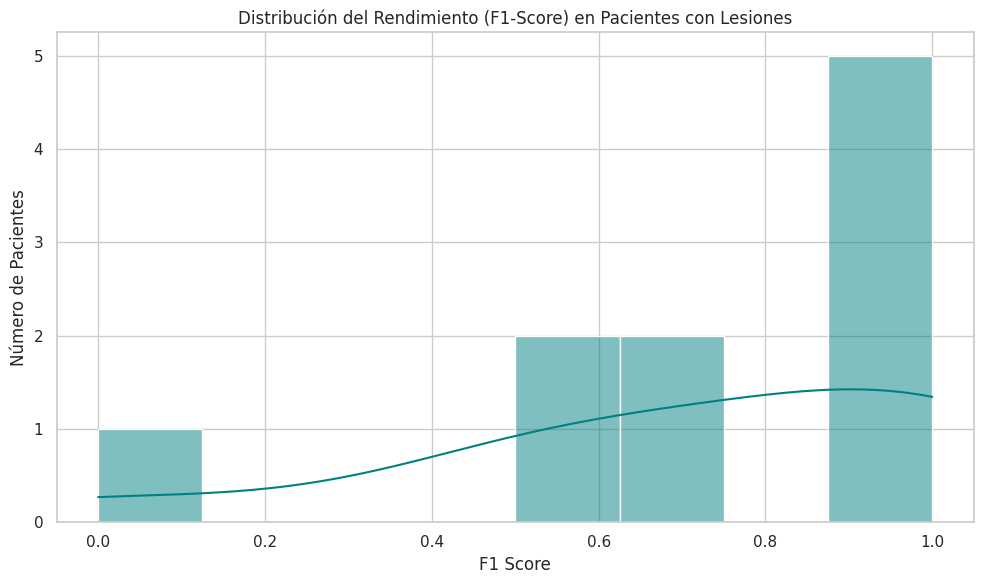

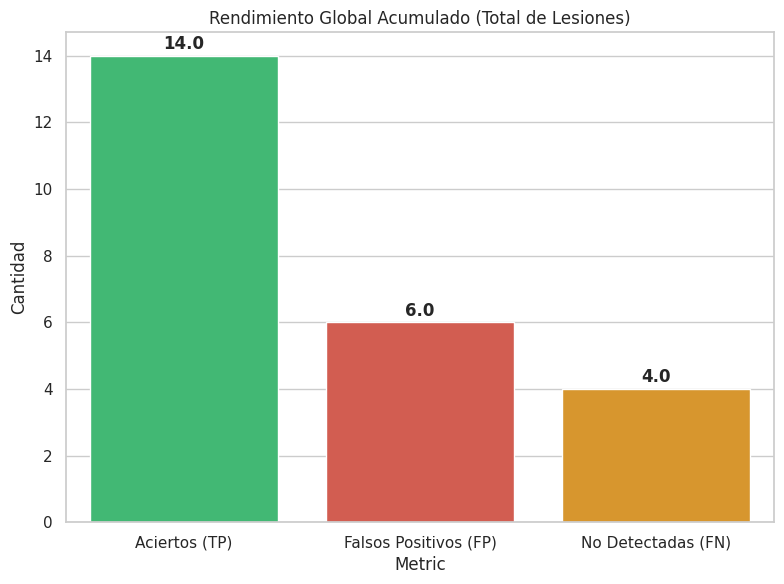

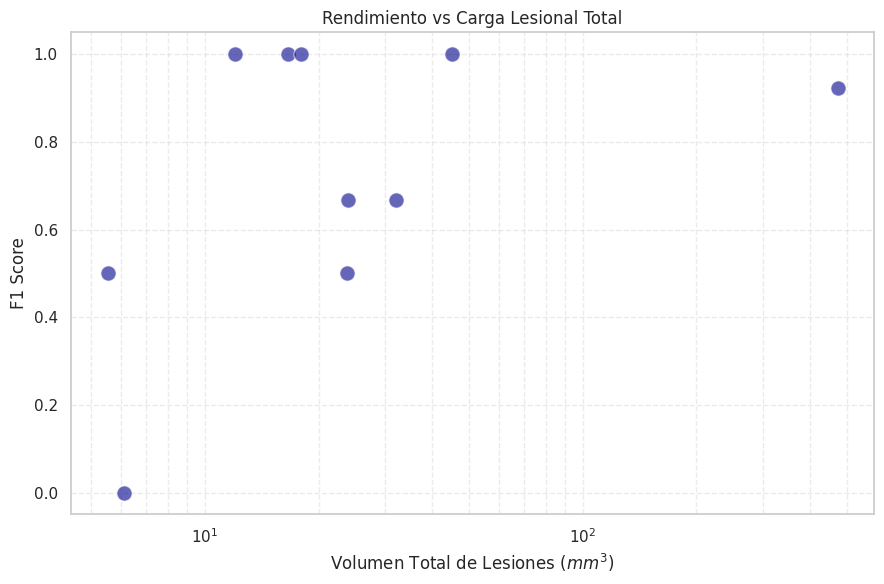

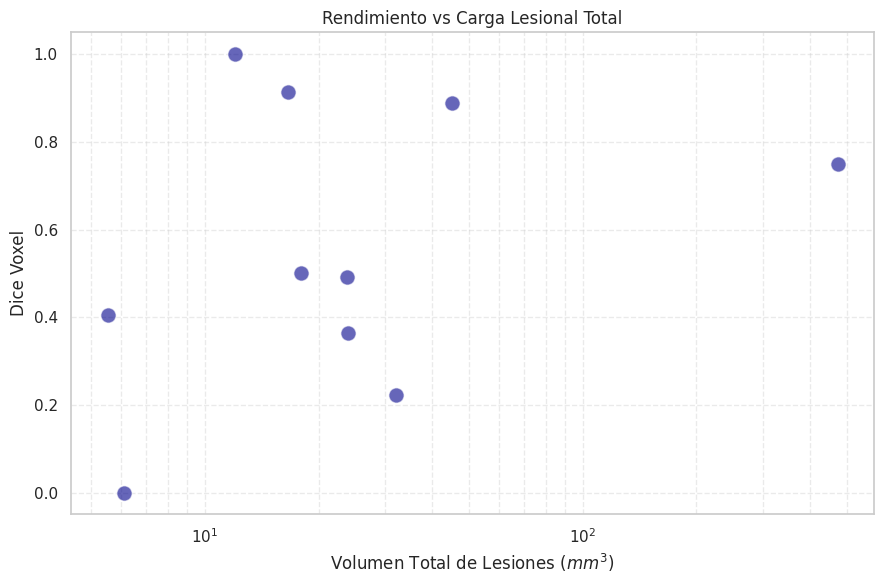

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
input_csv = "Resultados_Detallados_Ensemble_Filtrados.csv"
# ---------------------

# 1. Métricas Globales
metrics = ['F1_Score', 'Lesion_Recall', 'Lesion_Precision', 'Dice_Voxel']

# Estadísticas Generales
total_tp = df['TP'].sum()
total_fp = df['FP'].sum()
total_fn = df['FN'].sum()
recall_global_micro = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
precision_global_micro = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
f1_global_micro = 2 * (precision_global_micro * recall_global_micro) / (precision_global_micro + recall_global_micro)

print("\n=== RESUMEN GLOBAL (MICRO-AVERAGE) ===")
print(f"Total Aciertos (TP): {total_tp}")
print(f"Total Falsos Positivos (FP): {total_fp}")
print(f"Total Olvidos (FN): {total_fn}")
print(f"Recall Global (Micro): {recall_global_micro:.4f}")
print(f"Precisión Global (Micro): {precision_global_micro:.4f}")
print(f"F1 Global (Micro): {f1_global_micro:.4f}")

# 2. Métricas por Paciente (Macro-Average) - Solo Enfermos
df_sick = df[df['n_lesions_GT'] > 0].copy()
macro_stats = df_sick[metrics].mean()
print("\n=== RESUMEN POR PACIENTE (MACRO-AVERAGE, Solo Enfermos) ===")
print(macro_stats)

# --- GRÁFICOS ---
sns.set_theme(style="whitegrid")

# A. Histograma F1
plt.figure(figsize=(10, 6))
sns.histplot(df_sick['F1_Score'], bins=8, kde=True, color='teal')
plt.title('Distribución del Rendimiento (F1-Score) en Pacientes con Lesiones')
plt.xlabel('F1 Score')
plt.ylabel('Número de Pacientes')
plt.tight_layout()

# B. Barras de Error Total
plt.figure(figsize=(8, 6))
data_counts = pd.DataFrame({
    'Metric': ['Aciertos (TP)', 'Falsos Positivos (FP)', 'No Detectadas (FN)'],
    'Count': [total_tp, total_fp, total_fn]
})
sns.barplot(data=data_counts, x='Metric', y='Count', palette=['#2ecc71', '#e74c3c', '#f39c12'])
plt.title('Rendimiento Global Acumulado (Total de Lesiones)')
plt.ylabel('Cantidad')
for i, v in enumerate(data_counts['Count']):
    plt.text(i, v + 0.2, str(v), ha='center', fontweight='bold')
plt.tight_layout()

# C. Scatter Volumen vs F1
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df_sick, x='Total_Vol_GT_mm3', y='F1_Score', s=120, color='darkblue', alpha=0.6)
plt.xscale('log')
plt.title('Rendimiento vs Carga Lesional Total')
plt.xlabel('Volumen Total de Lesiones ($mm^3$)')
plt.ylabel('F1 Score')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()

# D. Scatter Volumen vs Dice
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df_sick, x='Total_Vol_GT_mm3', y='Dice_Voxel', s=120, color='darkblue', alpha=0.6)
plt.xscale('log')
plt.title('Rendimiento vs Carga Lesional Total')
plt.xlabel('Volumen Total de Lesiones ($mm^3$)')
plt.ylabel('Dice Voxel')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()